In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import os
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

from core.final.dataset import PSMDataset

In [72]:
"""
ts aux
period
lksl_statistic
rfr_score
amplitude
+
+ delta t t max - t min / 365
std
skew
kurtosis
etc

no mean min max

meta
+ l
+ b


spectra norm = (s - weighted med) / (med abs dev)
 + spectra flux error
 + aux mad only
  
results:
clip vs no clip classification on:
- photo
- spectra
- meta
- all

+ same on 10/25/50 split
+ plot embeddings
+ [future] gif with embeddings changing during training for each epoch for modalities AND classes
+ [future] outlier detection

"""

'\nts aux\nperiod\nlksl_statistic\nrfr_score\namplitude\n+\n+ delta t t max - t min / 365\nstd\nskew\nkurtosis\netc\n\nno mean min max\n\nmeta\n+ l\n+ b\n\n\nspectra norm = (s - weighted med) / (med abs dev)\n + spectra flux error\n + aux mad only\n  \nresults:\nclip vs no clip classification on:\n- photo\n- spectra\n- meta\n- all\n\n+ same on 10/25/50 split\n+ plot embeddings\n+ [future] gif with embeddings changing during training for each epoch for modalities AND classes\n+ [future] outlier detection\n\n'

In [2]:
METADATA_COLS = [
    'mean_vmag',  'phot_g_mean_mag', 'e_phot_g_mean_mag', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe', 'l', 'b'
]

PHOTO_COLS = ['amplitude', 'period', 'lksl_statistic', 'rfr_score']

METADATA_FUNC = {
    "abs": [
        "mean_vmag",
        "phot_g_mean_mag",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "j_mag",
        "h_mag",
        "k_mag",
        "w1_mag",
        "w2_mag",
        "w3_mag",
        "w4_mag",
    ],
    "cos": ["l"],
    "sin": ["b"],
    "log": ["period"]
}

In [47]:
def normalize_metadata(df_train, df_val, df_test, cols):
    scaler = StandardScaler()
    scaler.fit(df_train[cols])
    
    df_train.loc[:, cols] = scaler.transform(df_train[cols])
    df_val.loc[:, cols] = scaler.transform(df_val[cols])
    df_test.loc[:, cols] = scaler.transform(df_test[cols])

    return scaler

In [48]:
def transform(df):
    for transformation_type, value in METADATA_FUNC.items():
        if transformation_type == "abs":
            for col in value:
                df[col] = (
                    df[col] - 10 + 5 * np.log10(np.where(df["parallax"] <= 0, 1, df["parallax"]))
                )
        elif transformation_type == "cos":
            for col in value:
                df[col] = np.cos(np.radians(df[col]))
        elif transformation_type == "sin":
            for col in value:
                df[col] = np.sin(np.radians(df[col]))
        elif transformation_type == "log":
            for col in value:
                df[col] = np.log10(df[col])

In [62]:
train = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
val = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')
test = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

In [63]:
train['org_period'] = train['period']
val['org_period'] = val['period']
test['org_period'] = test['period']

In [64]:
train.head(3)

,mean_vmag,amplitude,period,phot_g_mean_mag,e_phot_g_mean_mag,lksl_statistic,rfr_score,phot_bp_mean_mag,e_phot_bp_mean_mag,phot_rp_mean_mag,...,w3_w4,pm,ruwe,id,target,name,spec_filename,l,b,org_period
0,14.25,0.43,0.369614,14.200958,0.008666,0.03,0.98,14.513055,0.026188,13.729204,...,3.193,3.727,1.075,EDR3 2117581746386552576,EW,ASASSN-VJ184120.05+445439.3,spec-57516-HD184435N434959B01_sp15-016.fits.gz,73.88900,20.46931,0.369614
1,13.18,0.36,0.412779,13.016400,0.006397,0.04,0.98,13.386993,0.018453,12.487576,...,2.322,3.993,6.687,EDR3 2827427930745553152,EW,ASASSN-VJ233021.18+214240.3,spec-56967-EG232823N195308V01_sp11-063.fits.gz,99.03928,-37.36992,0.412779
2,12.97,0.36,0.450261,12.832680,0.008542,0.02,0.99,13.101369,0.024287,12.416662,...,2.970,15.718,1.217,EDR3 925880840326498432,EW,ASASSN-VJ074727.40+433956.1,spec-57410-HD075322N454428V02_sp02-117.fits.gz,175.63313,28.07546,0.450261


In [65]:
transform(train)
transform(val)
transform(test)

In [66]:
train.head(3)

,mean_vmag,amplitude,period,phot_g_mean_mag,e_phot_g_mean_mag,lksl_statistic,rfr_score,phot_bp_mean_mag,e_phot_bp_mean_mag,phot_rp_mean_mag,...,w3_w4,pm,ruwe,id,target,name,spec_filename,l,b,org_period
0,3.642896,0.43,-0.432251,3.593854,0.008666,0.03,0.98,3.905951,0.026188,3.122100,...,3.193,3.727,1.075,EDR3 2117581746386552576,EW,ASASSN-VJ184120.05+445439.3,spec-57516-HD184435N434959B01_sp15-016.fits.gz,0.277499,0.349706,0.369614
1,3.417348,0.36,-0.384283,3.253748,0.006397,0.04,0.98,3.624341,0.018453,2.724924,...,2.322,3.993,6.687,EDR3 2827427930745553152,EW,ASASSN-VJ233021.18+214240.3,spec-56967-EG232823N195308V01_sp11-063.fits.gz,-0.157112,-0.606959,0.412779
2,3.271222,0.36,-0.346536,3.133902,0.008542,0.02,0.99,3.402591,0.024287,2.717884,...,2.970,15.718,1.217,EDR3 925880840326498432,EW,ASASSN-VJ074727.40+433956.1,spec-57410-HD075322N454428V02_sp02-117.fits.gz,-0.997097,0.470634,0.450261


In [67]:
scaler = normalize_metadata(train, val, test, cols=METADATA_COLS+PHOTO_COLS)

In [68]:
train.head(3)

,mean_vmag,amplitude,period,phot_g_mean_mag,e_phot_g_mean_mag,lksl_statistic,rfr_score,phot_bp_mean_mag,e_phot_bp_mean_mag,phot_rp_mean_mag,...,w3_w4,pm,ruwe,id,target,name,spec_filename,l,b,org_period
0,0.468452,-0.123730,-0.750512,0.577753,0.337026,-1.109518,1.036339,0.480426,0.077119,0.622243,...,0.682490,-0.451806,-0.180783,EDR3 2117581746386552576,EW,ASASSN-VJ184120.05+445439.3,spec-57516-HD184435N434959B01_sp15-016.fits.gz,1.003911,0.444250,0.369614
1,0.377716,-0.273548,-0.705325,0.455826,-0.124239,-1.072690,1.036339,0.367259,-0.178151,0.488187,...,0.006407,-0.425981,1.996158,EDR3 2827427930745553152,EW,ASASSN-VJ233021.18+214240.3,spec-56967-EG232823N195308V01_sp11-063.fits.gz,0.356090,-1.547098,0.412779
2,0.318932,-0.273548,-0.669766,0.412862,0.311818,-1.146347,1.108638,0.278147,0.014382,0.485811,...,0.509394,0.712358,-0.125700,EDR3 925880840326498432,EW,ASASSN-VJ074727.40+433956.1,spec-57410-HD075322N454428V02_sp02-117.fits.gz,-0.895975,0.695969,0.450261


In [69]:
train.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train_norm.csv', index=False)
val.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val_norm.csv', index=False)
test.to_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test_norm.csv', index=False)

In [73]:
joblib.dump(scaler, '/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/scaler.pkl')

['/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/scaler.pkl']

# Test

In [3]:
CLASSES = ['EW', 'SR', 'EA', 'RRAB', 'EB', 'ROT', 'RRC', 'HADS', 'M', 'DSCT']

In [4]:
def get_config():
    config = {
        'project': 'AstroCLIPResults',
        'mode': 'meta',    # 'clip' 'photo' 'spectra' 'meta' 'all'
        'config_from': None,    # 'meridk/AstroCLIPResults/zgfcm56p',
        'random_seed': 42,  # 42, 66, 0, 12, 123
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        # 'use_pretrain': 'CLIP/home/mariia/AstroML/weights/2024-08-14-14-05-zmjau1cu/weights-51.pth',
        'use_pretrain': None,
        'freeze': False,

        # Data General
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'preprocessed_data/full_lb/spectra_and_v',
        'classes': CLASSES,
        'num_classes': len(CLASSES),
        'meta_cols': METADATA_COLS,
        'photo_cols': PHOTO_COLS,
        'min_samples': None,
        'max_samples': None,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': False,
        'p_aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        's_aux': True,
        's_err': True,

        # Photometry Model
        'p_enc_in': 3,
        'p_d_model': 128,
        'p_dropout': 0.2,
        'p_factor': 1,
        'p_output_attention': False,
        'p_n_heads': 4,
        'p_d_ff': 512,
        'p_activation': 'gelu',
        'p_e_layers': 8,

        # Spectra Model
        's_dropout': 0.2,
        's_conv_channels': [1, 64, 64, 32, 32],
        's_kernel_size': 3,
        's_mp_kernel_size': 4,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0.2,

        # MultiModal Model
        'hidden_dim': 512,
        'fusion': 'avg',  # 'avg', 'concat'

        # Training
        'batch_size': 512,
        'lr': 0.001,
        'beta1': 0.9,
        'beta2': 0.999,
        'weight_decay': 0.01,
        'epochs': 100,
        'early_stopping_patience': 6,
        'scheduler': 'ReduceLROnPlateau',  # 'ExponentialLR', 'ReduceLROnPlateau'
        'gamma': 0.9,  # for ExponentialLR scheduler
        'factor': 0.3,  # for ReduceLROnPlateau scheduler
        'patience': 3,  # for ReduceLROnPlateau scheduler
        'warmup': True,
        'warmup_epochs': 10,
        'clip_grad': True,
        'clip_value': 45
    }

    if config['p_aux']:
        config['p_enc_in'] += len(config['photo_cols']) + 2     # +2 for mad and delta t

    if config['s_aux']:
        config['s_conv_channels'][0] += 1

    if config['s_err']:
        config['s_conv_channels'][0] += 1

    if config['config_from']:
        print(f"Copying params from the {config['config_from']} run")
        old_config = wandb.Api().run(config['config_from']).config

        for el in old_config:
            if el in [
                'p_dropout', 's_dropout', 'm_dropout', 'lr', 'beta1', 'weight_decay', 'epochs',
                'early_stopping_patience', 'factor', 'patience', 'warmup', 'warmup_epochs', 'clip_grad', 'clip_value',
                'use_pretrain', 'freeze', 'phased', 'p_aux', 'p_enc_in', 's_aux', 's_err', 's_conv_channels'
            ]:
                config[el] = old_config[el]

    return config

In [5]:
config = get_config()

In [6]:
train_dataset = PSMDataset(config, split='train')

In [8]:
p, p_m, s, m, l = train_dataset[0]

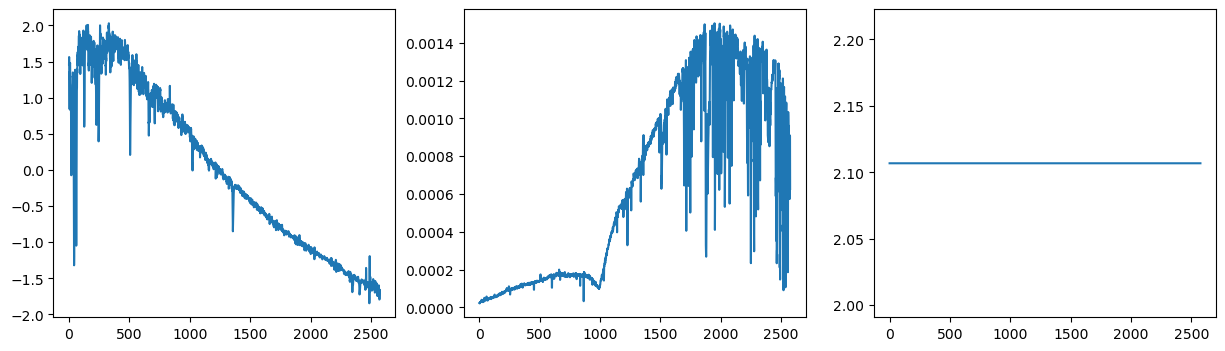

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(s[:, 0])
axs[1].plot(s[:, 1])
axs[2].plot(s[:, 2])

In [23]:
m.shape

(34,)

In [24]:
m

array([ 0.46845165,  0.5777532 ,  0.33702573,  0.48042554,  0.07711897,
        0.6222429 ,  0.5225165 , -0.5712912 , -0.08947697, -0.4166497 ,
        0.12132795,  0.13869835, -0.38648468,  0.1050081 , -0.29492944,
        0.6661094 ,  0.574305  ,  0.709537  ,  0.02201757,  0.7009008 ,
       -0.05441045,  0.66980654, -0.36477575,  0.6715334 , -0.34695286,
        0.8064633 ,  0.6847023 , -0.77802926, -0.22493474,  0.68248993,
       -0.45180646, -0.18078335,  1.0039113 ,  0.44424993], dtype=float32)

In [25]:
train_dataset.meta_cols

['mean_vmag',
 'phot_g_mean_mag',
 'e_phot_g_mean_mag',
 'phot_bp_mean_mag',
 'e_phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'e_phot_rp_mean_mag',
 'bp_rp',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'j_mag',
 'e_j_mag',
 'h_mag',
 'e_h_mag',
 'k_mag',
 'e_k_mag',
 'w1_mag',
 'e_w1_mag',
 'w2_mag',
 'e_w2_mag',
 'w3_mag',
 'w4_mag',
 'j_k',
 'w1_w2',
 'w3_w4',
 'pm',
 'ruwe',
 'l',
 'b']

In [27]:
p.shape

(200, 9)

In [28]:
p[:3, :]

array([[ 0.00000000e+00,  1.57550907e+00,  2.60645151e-01,
        -1.23729676e-01, -7.50512242e-01, -1.10951817e+00,
         1.03633916e+00, -1.10698298e-01,  2.93458486e+00],
       [ 9.33067000e-04, -3.26426387e-01,  2.36129031e-01,
        -1.23729676e-01, -7.50512242e-01, -1.10951817e+00,
         1.03633916e+00, -1.10698298e-01,  2.93458486e+00],
       [ 1.86934567e-03,  1.74218774e-01,  2.42580652e-01,
        -1.23729676e-01, -7.50512242e-01, -1.10951817e+00,
         1.03633916e+00, -1.10698298e-01,  2.93458486e+00]], dtype=float32)

In [60]:
for i in tqdm(range(len(train_dataset))):
    el = train_dataset.df.iloc[i]
    spectra = train_dataset.readLRSFits(os.path.join(train_dataset.lamost_spec_dir, el['spec_filename'])) 
    
    wavelengths = spectra[:, 0]
    flux = spectra[:, 1]
    
    new_wavelengths = np.arange(3850, 9000, 2)
    flux = np.interp(new_wavelengths, wavelengths, flux)
    
    mad = stats.median_abs_deviation(flux[flux != 0])
    
    if mad < 1:
        print(i, mad)

  0%|▎                                                                              | 80/17275 [00:01<03:51, 74.36it/s]

64 0.46285699110724954


  1%|▌                                                                             | 125/17275 [00:01<03:31, 80.90it/s]

110 0.5609253963675846


  2%|█▏                                                                            | 273/17275 [00:03<03:17, 85.88it/s]

260 0.04108158807117304


  3%|██▍                                                                           | 546/17275 [00:07<03:48, 73.26it/s]

530 0.6651917778121099
532 0.7981359602913027


  3%|██▌                                                                           | 571/17275 [00:07<03:52, 71.80it/s]

563 0.06897711589985991


  4%|██▊                                                                           | 623/17275 [00:08<03:45, 73.81it/s]

615 0.5485547160626307


  4%|███▍                                                                          | 749/17275 [00:09<03:36, 76.50it/s]

734 0.1307119385803558


  6%|████▎                                                                         | 968/17275 [00:12<03:13, 84.38it/s]

953 0.4990572184005464


  8%|█████▉                                                                       | 1334/17275 [00:17<03:42, 71.58it/s]

1325 0.4919639906689113
1332 0.6963656427387654


  9%|███████                                                                      | 1581/17275 [00:20<03:07, 83.87it/s]

1563 0.5620792228682108


  9%|███████▏                                                                     | 1626/17275 [00:21<03:22, 77.30it/s]

1618 0.8426101130518231


 10%|███████▎                                                                     | 1645/17275 [00:21<03:20, 77.93it/s]

1636 0.498484806634758


 11%|████████                                                                     | 1816/17275 [00:23<02:54, 88.59it/s]

1799 0.32695238986158187


 12%|████████▊                                                                    | 1987/17275 [00:25<02:58, 85.72it/s]

1971 0.9439516804174963


 12%|█████████                                                                    | 2033/17275 [00:26<03:12, 79.04it/s]

2020 0.5886702684652292


 12%|█████████▏                                                                   | 2061/17275 [00:26<03:07, 81.22it/s]

2051 0.40062405917336186


 12%|█████████▎                                                                   | 2087/17275 [00:26<03:11, 79.47it/s]

2072 0.2881770288750731
2077 0.2864420338279323


 13%|█████████▊                                                                   | 2194/17275 [00:28<02:37, 95.51it/s]

2179 0.5165127641893537
2185 0.22025843956578794


 13%|█████████▊                                                                   | 2214/17275 [00:28<02:58, 84.15it/s]

2205 0.30358039122743596
2207 0.5606373888773866


 13%|██████████                                                                   | 2253/17275 [00:28<02:47, 89.73it/s]

2237 0.8234644669745994


 14%|██████████▌                                                                  | 2376/17275 [00:30<02:46, 89.74it/s]

2366 0.14868487954487386


 15%|███████████▋                                                                 | 2619/17275 [00:32<02:40, 91.25it/s]

2603 0.5526154963598096


 16%|████████████                                                                 | 2705/17275 [00:33<02:54, 83.53it/s]

2696 0.7245464525769933
2713 0.6684155862601067


 16%|████████████▎                                                                | 2765/17275 [00:34<02:57, 81.86it/s]

2749 0.6480191739597223
2751 0.8863754863978142


 16%|████████████▋                                                                | 2844/17275 [00:35<02:41, 89.09it/s]

2827 0.2488559530885719


 17%|████████████▉                                                                | 2903/17275 [00:36<02:46, 86.26it/s]

2887 0.950443994028257
2900 0.5867893719547865


 17%|█████████████▏                                                               | 2949/17275 [00:36<02:44, 87.35it/s]

2931 0.4844298338067674


 17%|█████████████▎                                                               | 2982/17275 [00:36<02:26, 97.85it/s]

2965 0.4732710062705001
2982 0.1718570824667457


 17%|█████████████▍                                                               | 3011/17275 [00:37<02:49, 84.09it/s]

2996 0.42679929227801594
2999 0.5729351226726251
3006 0.6353462825471055


 18%|█████████████▋                                                               | 3066/17275 [00:37<02:48, 84.24it/s]

3052 0.39976531991914227
3055 0.9278226645764489


 18%|█████████████▉                                                               | 3139/17275 [00:38<02:46, 85.08it/s]

3128 0.5802504071941077


 18%|██████████████▏                                                              | 3180/17275 [00:39<02:36, 90.25it/s]

3168 0.8698207062415726
3183 0.8853818202241683


 19%|██████████████▍                                                              | 3234/17275 [00:39<02:26, 95.93it/s]

3222 0.9442983564531207
3236 0.11043198403195564


 19%|██████████████▋                                                              | 3307/17275 [00:40<02:32, 91.52it/s]

3291 0.5003986799860416
3302 0.5646869208665057
3303 0.7758628843090762


 20%|███████████████                                                              | 3379/17275 [00:41<02:27, 94.18it/s]

3360 0.18011297092780698


 20%|███████████████▎                                                             | 3429/17275 [00:41<02:27, 94.05it/s]

3417 0.285639335972398
3422 0.17859460890586742


 20%|███████████████▌                                                             | 3490/17275 [00:42<02:39, 86.32it/s]

3479 0.4515896417941552


 20%|███████████████▊                                                             | 3541/17275 [00:43<02:26, 93.46it/s]

3528 0.07420176830646258


 21%|████████████████▏                                                            | 3621/17275 [00:44<02:32, 89.71it/s]

3608 0.5072610318148794
3617 0.4363329998806369
3620 0.2672061691519829
3626 0.8564499202779494
3627 0.5671080671020299


 22%|████████████████▌                                                            | 3723/17275 [00:45<02:19, 96.93it/s]

3711 0.2322417541175626


 23%|█████████████████▋                                                           | 3975/17275 [00:47<02:42, 81.98it/s]

3959 0.07571348007869316


 23%|█████████████████▍                                                         | 4004/17275 [01:19<3:15:29,  1.13it/s]

3995 0.4029256617064263


 23%|█████████████████▍                                                         | 4029/17275 [01:19<1:04:52,  3.40it/s]

4014 0.3001924736897741
4020 0.5437670540715003


 25%|███████████████████▌                                                         | 4376/17275 [01:24<02:57, 72.65it/s]

4364 0.3439353999398278


 27%|████████████████████▍                                                        | 4579/17275 [01:27<02:40, 79.33it/s]

4566 0.9007105158121185


 27%|████████████████████▊                                                        | 4677/17275 [01:28<02:59, 70.22it/s]

4667 0.6592457019720617


 29%|██████████████████████                                                       | 4945/17275 [01:32<03:18, 62.13it/s]

4937 0.6668485230658137


 29%|██████████████████████▍                                                      | 5038/17275 [01:33<02:33, 79.80it/s]

5028 0.30442504979864826


 29%|██████████████████████▌                                                      | 5072/17275 [01:34<02:42, 75.26it/s]

5063 0.26572627976708896


 29%|██████████████████████▋                                                      | 5096/17275 [01:34<02:51, 71.06it/s]

5082 0.12956243813472668


 30%|██████████████████████▊                                                      | 5128/17275 [01:35<02:50, 71.17it/s]

5114 0.5498811608937437


 30%|███████████████████████                                                      | 5178/17275 [01:35<03:00, 67.11it/s]

5168 0.4152839416452405
5176 0.20006143536409626


 31%|███████████████████████▋                                                     | 5320/17275 [01:37<02:55, 68.03it/s]

5309 0.3088960383194488


 31%|███████████████████████▊                                                     | 5353/17275 [01:38<02:45, 71.88it/s]

5342 0.2733231047519271


 31%|████████████████████████                                                     | 5403/17275 [01:39<02:42, 73.03it/s]

5390 0.8874719698015845
5404 0.3437137981842986


 32%|████████████████████████▎                                                    | 5442/17275 [01:39<02:57, 66.50it/s]

5434 0.24521824585119756
5438 0.3490114713250918


 32%|████████████████████████▍                                                    | 5471/17275 [01:40<03:20, 58.77it/s]

5465 0.2917929991060899


 32%|████████████████████████▋                                                    | 5548/17275 [01:41<03:13, 60.53it/s]

5538 0.3251720494952135


 34%|██████████████████████████▎                                                  | 5901/17275 [01:46<02:45, 68.78it/s]

5894 0.3255584528539135


 35%|███████████████████████████                                                  | 6066/17275 [01:49<02:34, 72.47it/s]

6051 0.8090343716063555


 35%|███████████████████████████                                                  | 6082/17275 [01:49<02:45, 67.77it/s]

6069 0.1394816202913495


 36%|███████████████████████████▋                                                 | 6206/17275 [01:51<02:54, 63.34it/s]

6195 0.10211782572415484


 36%|███████████████████████████▊                                                 | 6235/17275 [01:51<02:49, 65.31it/s]

6227 0.24325498689980396


 37%|████████████████████████████▍                                                | 6375/17275 [01:53<02:44, 66.41it/s]

6364 0.2573211684496144


 37%|████████████████████████████▋                                                | 6431/17275 [01:54<02:26, 73.78it/s]

6417 0.10423687070333354


 42%|████████████████████████████████▍                                            | 7275/17275 [02:07<02:22, 70.28it/s]

7260 0.4855332589767756


 43%|█████████████████████████████████▎                                           | 7466/17275 [02:10<02:39, 61.52it/s]

7458 0.3779053842365565


 44%|█████████████████████████████████▌                                           | 7537/17275 [02:11<02:19, 70.04it/s]

7523 0.6469794943139564


 45%|██████████████████████████████████▋                                          | 7785/17275 [02:15<02:09, 73.45it/s]

7770 0.4153151040018379


 45%|██████████████████████████████████▊                                          | 7800/17275 [02:15<02:22, 66.64it/s]

7791 0.37470236969546455


 53%|████████████████████████████████████████▊                                    | 9159/17275 [02:34<01:58, 68.32it/s]

9149 0.9840385748263345
9157 0.9310942606182082


 57%|███████████████████████████████████████████▌                                 | 9772/17275 [02:43<01:47, 69.56it/s]

9760 0.7529928780506141


 60%|█████████████████████████████████████████████▏                              | 10280/17275 [02:50<01:25, 81.59it/s]

10269 0.4238805012035082


 60%|█████████████████████████████████████████████▍                              | 10317/17275 [02:51<01:26, 80.47it/s]

10309 0.09717977852912107
10321 0.1168113928694221


 63%|███████████████████████████████████████████████▌                            | 10823/17275 [02:56<01:09, 93.32it/s]

10808 0.3403975751406263
10826 0.5189919795754068


 63%|███████████████████████████████████████████████                            | 10845/17275 [02:57<01:03, 101.02it/s]

10828 0.15919518018938583


 64%|████████████████████████████████████████████████▍                           | 10998/17275 [02:58<01:11, 87.41it/s]

10983 0.2661793167280171


 64%|████████████████████████████████████████████████▌                           | 11037/17275 [02:59<01:09, 89.55it/s]

11022 0.7617746442042161


 64%|████████████████████████████████████████████████▉                           | 11120/17275 [03:00<01:02, 98.02it/s]

11106 0.42597665968102705


 65%|█████████████████████████████████████████████████▍                          | 11235/17275 [03:01<01:00, 99.93it/s]

11218 0.9781887872236377


 66%|██████████████████████████████████████████████████▍                         | 11475/17275 [03:03<00:58, 99.61it/s]

11455 0.8195302258448898


 69%|████████████████████████████████████████████████████▊                       | 12000/17275 [03:09<00:57, 91.04it/s]

11983 0.21040550329806618


 73%|██████████████████████████████████████████████████████▌                    | 12556/17275 [03:15<00:45, 103.85it/s]

12537 0.1497471840325797


 73%|███████████████████████████████████████████████████████▍                    | 12598/17275 [03:15<00:57, 81.86it/s]

12592 0.7456292781733054


 73%|███████████████████████████████████████████████████████▊                    | 12679/17275 [03:16<00:47, 97.33it/s]

12661 0.08920189297019321


 75%|████████████████████████████████████████████████████████▋                   | 12896/17275 [03:19<00:48, 91.06it/s]

12883 0.4759994839867795


 76%|█████████████████████████████████████████████████████████▍                  | 13054/17275 [03:20<00:46, 91.43it/s]

13039 0.8771154703776172


 76%|█████████████████████████████████████████████████████████▊                  | 13138/17275 [03:21<00:44, 93.74it/s]

13125 0.22231358536617485


 77%|██████████████████████████████████████████████████████████▌                 | 13302/17275 [03:23<00:48, 81.73it/s]

13287 0.7946784592419123


 77%|██████████████████████████████████████████████████████████▋                 | 13344/17275 [03:23<00:40, 96.01it/s]

13335 0.9897695347705426


 78%|███████████████████████████████████████████████████████████▎                | 13491/17275 [03:25<00:45, 83.60it/s]

13482 0.2743204862090258


 82%|██████████████████████████████████████████████████████████████▌             | 14225/17275 [03:34<00:49, 61.51it/s]

14217 0.2606104191078509


 83%|██████████████████████████████████████████████████████████████▊             | 14285/17275 [03:35<00:37, 78.76it/s]

14274 0.3086695763802445


 84%|███████████████████████████████████████████████████████████████▊            | 14504/17275 [03:38<00:39, 69.35it/s]

14489 0.11141759627946857


 86%|█████████████████████████████████████████████████████████████████▌          | 14899/17275 [03:44<00:31, 75.39it/s]

14890 0.23583265912013052


 87%|██████████████████████████████████████████████████████████████████          | 15012/17275 [03:46<00:32, 70.65it/s]

15003 0.8850064024102088


 88%|██████████████████████████████████████████████████████████████████▋         | 15167/17275 [03:48<00:34, 60.94it/s]

15158 0.01018542238358132


 89%|███████████████████████████████████████████████████████████████████▎        | 15299/17275 [03:50<00:28, 70.27it/s]

15286 0.5625740323265549


 89%|███████████████████████████████████████████████████████████████████▌        | 15344/17275 [03:50<00:27, 69.53it/s]

15335 0.30231394232719566


 89%|███████████████████████████████████████████████████████████████████▊        | 15417/17275 [03:51<00:25, 71.78it/s]

15411 0.6845193140395001


 89%|███████████████████████████████████████████████████████████████████▉        | 15442/17275 [03:52<00:25, 71.78it/s]

15427 0.3439723646974504


 90%|████████████████████████████████████████████████████████████████████▌       | 15594/17275 [03:54<00:23, 71.30it/s]

15582 0.8839313286165948


 91%|█████████████████████████████████████████████████████████████████████       | 15700/17275 [03:56<00:22, 70.95it/s]

15691 0.651270462656723


 91%|█████████████████████████████████████████████████████████████████████▍      | 15790/17275 [03:57<00:19, 74.40it/s]

15779 0.24825581714386358


 92%|█████████████████████████████████████████████████████████████████████▋      | 15844/17275 [03:58<00:20, 71.16it/s]

15830 0.7949647278082956


 93%|██████████████████████████████████████████████████████████████████████▎     | 15981/17275 [04:00<00:22, 57.68it/s]

15970 0.19227784950247395


 93%|██████████████████████████████████████████████████████████████████████▋     | 16059/17275 [04:01<00:18, 65.42it/s]

16045 0.7224051030108631


 95%|████████████████████████████████████████████████████████████████████████    | 16385/17275 [04:06<00:12, 70.70it/s]

16373 0.8231175431005138


 95%|████████████████████████████████████████████████████████████████████████▍   | 16467/17275 [04:07<00:12, 65.73it/s]

16460 0.7677096163830184


 96%|████████████████████████████████████████████████████████████████████████▋   | 16525/17275 [04:08<00:10, 68.49it/s]

16512 0.30879315559911724


 96%|█████████████████████████████████████████████████████████████████████████   | 16619/17275 [04:09<00:09, 69.01it/s]

16605 0.8767905537563605


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16641/17275 [04:10<00:09, 69.19it/s]

16629 0.30531002188402034


100%|██████████████████████████████████████████████████████████████████████████▋| 17200/17275 [04:16<00:00, 101.25it/s]

17187 0.12879931971271785


100%|████████████████████████████████████████████████████████████████████████████| 17275/17275 [04:17<00:00, 67.01it/s]

17259 0.24384961691664087


In [41]:
stds = []

for i in tqdm(range(100)):
    el = train_dataset.df.iloc[i]
    spectra = train_dataset.readLRSFits(os.path.join(train_dataset.lamost_spec_dir, el['spec_filename'])) 
    
    wavelengths = spectra[:, 0]
    flux = spectra[:, 1]
    
    new_wavelengths = np.arange(3850, 9000, 2)
    flux = np.interp(new_wavelengths, wavelengths, flux)
    stds.append(np.std(flux))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.33it/s]


In [47]:
np.mean(stds), np.mean([np.log10(el) for el in stds]), np.min([np.log10(el) for el in stds]), np.max([np.log10(el) for el in stds])

(587.2713384487996, 2.181350423034199, -0.16861374035436197, 4.154715670123909)

In [26]:
el = train_dataset.df.iloc[333]
spectra = train_dataset.readLRSFits(os.path.join(train_dataset.lamost_spec_dir, el['spec_filename'])) 

wavelengths = spectra[:, 0]
flux = spectra[:, 1]

new_wavelengths = np.arange(3850, 9000, 2)
flux = np.interp(new_wavelengths, wavelengths, flux)

mean = np.mean(flux)
mad = stats.median_abs_deviation(flux[flux != 0])
std = np.std(flux)

flux_mad = (flux - mean) / mad
flux_mad_scaled = (flux - mean) / (mad * 1.5)
flux_std = (flux - mean) / std
flux_max_std = (flux - mean) / (0.5 * mad + 0.5 * std)

print(mad, std)

85.1247910831828 290.9591462733794


In [40]:
np.log10(std)

2.463832013750174

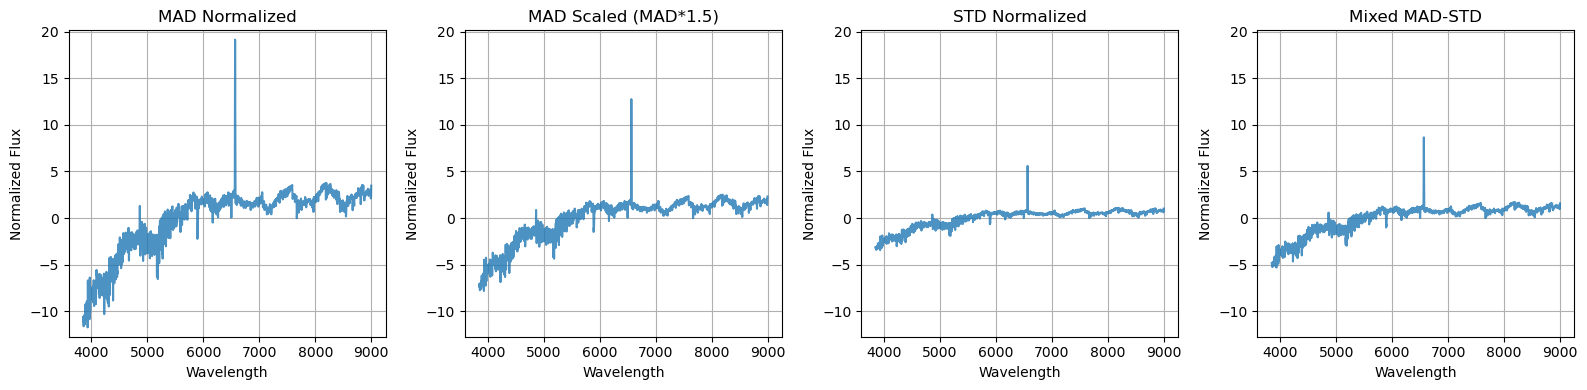

In [39]:
y_min = min(flux_mad.min(), flux_mad_scaled.min(), flux_std.min(), flux_max_std.min()) - 1
y_max = max(flux_mad.max(), flux_mad_scaled.max(), flux_std.max(), flux_max_std.max()) + 1

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(new_wavelengths, flux_mad, label="MAD Normalized", alpha=0.8)
plt.ylim(y_min, y_max)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('MAD Normalized')
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(new_wavelengths, flux_mad_scaled, label="MAD Scaled (MAD*1.5)", alpha=0.8)
plt.ylim(y_min, y_max)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('MAD Scaled (MAD*1.5)')
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(new_wavelengths, flux_std, label="STD Normalized", alpha=0.8)
plt.ylim(y_min, y_max)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('STD Normalized')
plt.grid(True)

plt.subplot(1, 4, 4)
plt.plot(new_wavelengths, flux_max_std, label="Mixed MAD-STD", alpha=0.8)
plt.ylim(y_min, y_max)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Flux')
plt.title('Mixed MAD-STD')
plt.grid(True)

plt.tight_layout()
plt.show()

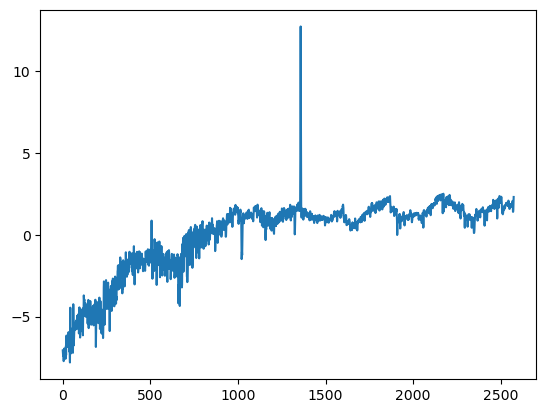

In [25]:
plt.plot(flux_norm_scaled)

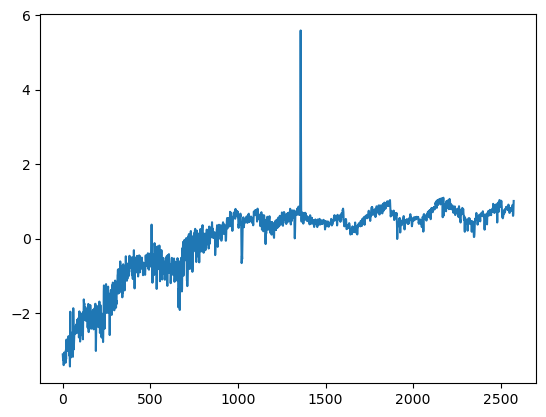

In [23]:
plt.plot(flux_std_norm)

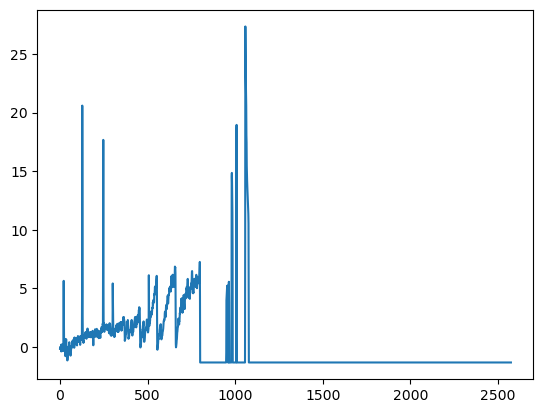

In [59]:
plt.plot(flux_norm)

In [9]:
def plot_spectra(i):
    p, p_m, s, m, l = train_dataset[i]
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    
    axs[0].plot(s[0, :])
    axs[1].plot(s[1, :])
    axs[2].plot(s[2, :])

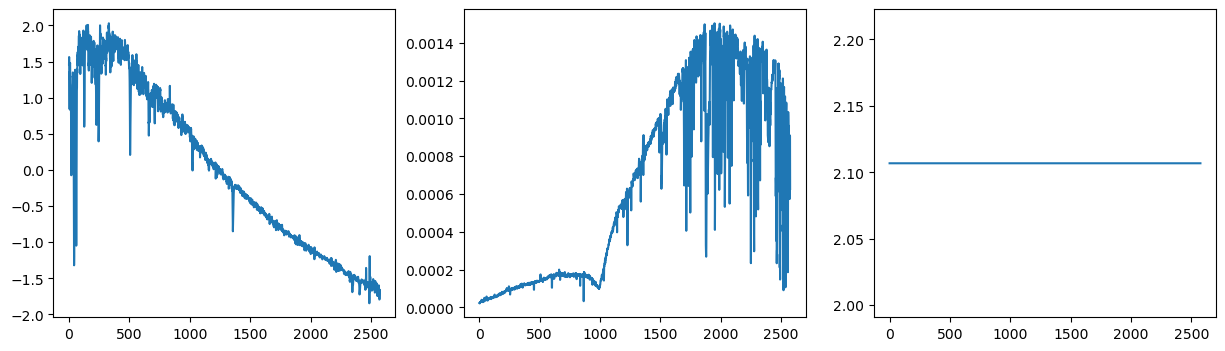

In [11]:
plot_spectra(0)

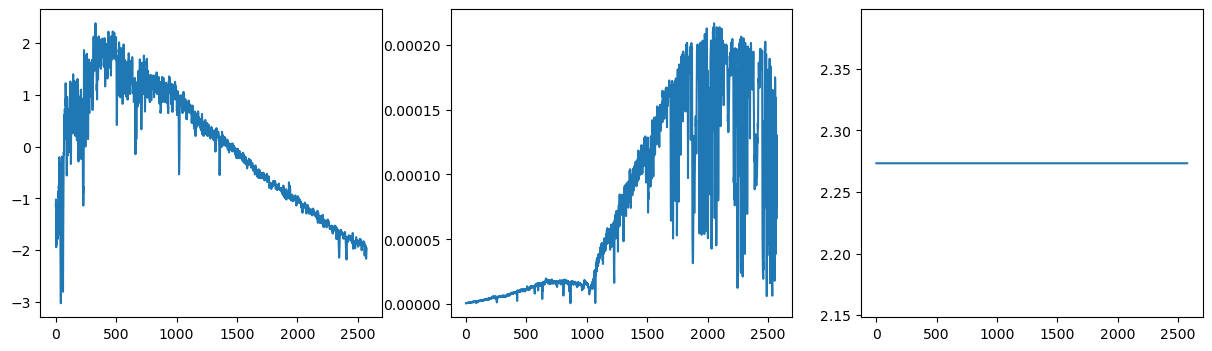

In [12]:
plot_spectra(10)

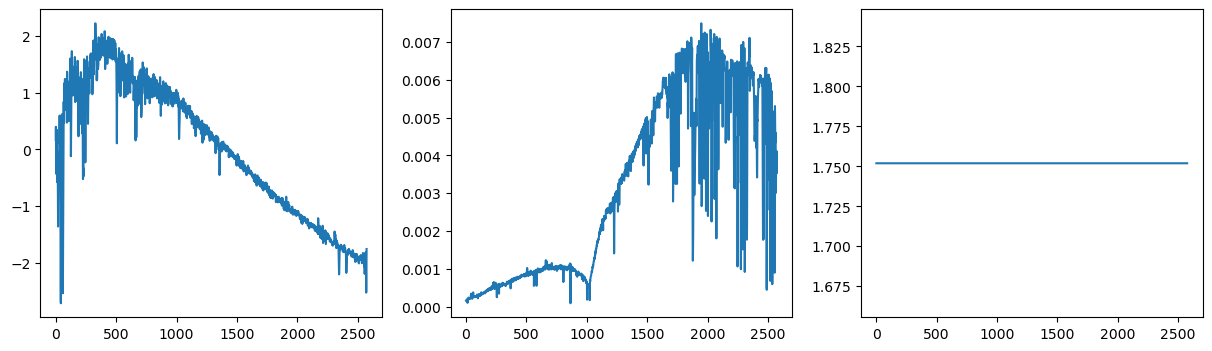

In [13]:
plot_spectra(100)

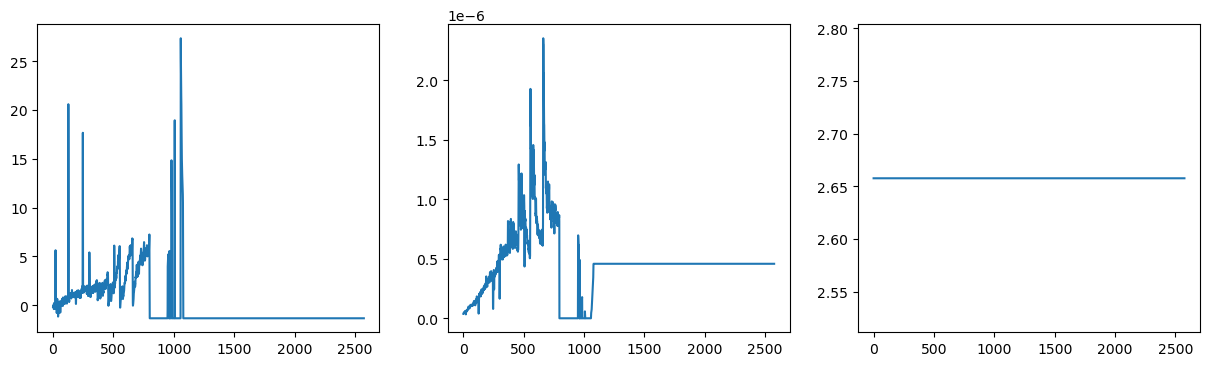

In [14]:
plot_spectra(7958)

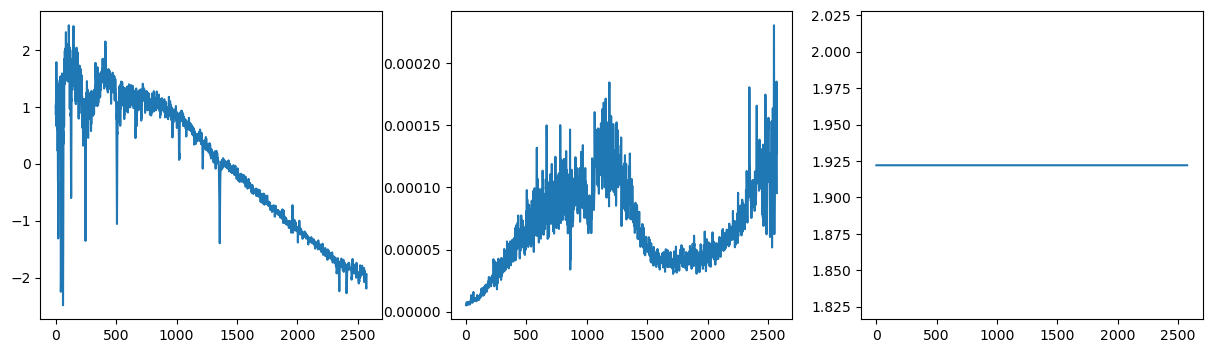

In [15]:
plot_spectra(222)

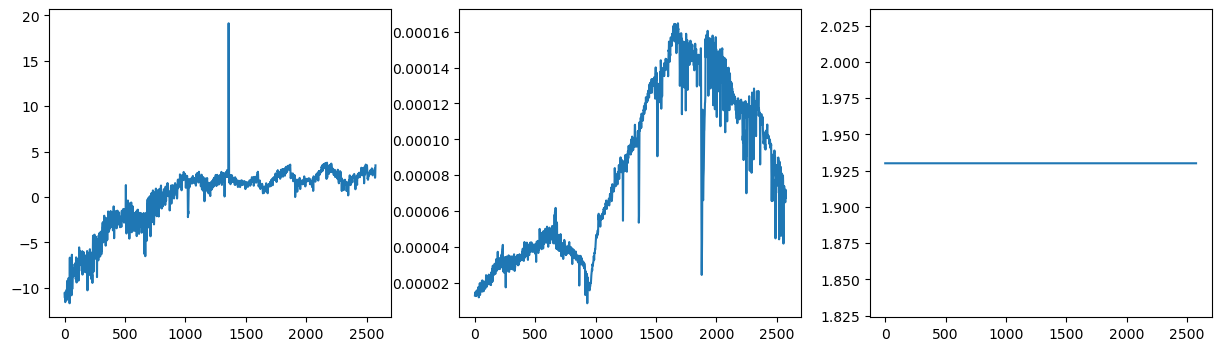

In [16]:
plot_spectra(333)